# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# Load games requirements table
games_requirement_data = pd.read_csv('../tables/games_requirement_data.csv', index_col=0)

# Load benchmark score table
benchmark_score_data = pd.read_csv('../tables/benchmark_score_data.csv', index_col=0)

# Load GPU table
gpu_data = pd.read_csv('../tables/gpu_data.csv', index_col=0)

# Load RAM table
ram_data = pd.read_csv('../tables/ram_data.csv', index_col=0)

# Handling Null Values

In [3]:
def null_values(df):
    for column in df.columns:
        null_count = df[column].isna().sum()
        if (null_count>0):
            print(f'{column}: {null_count} null values')    

In [4]:
null_values(games_requirement_data)

gpu_minimum_benchmark_score: 7 null values
gpu_recommended_benchmark_score: 2 null values


In [5]:
null_values(benchmark_score_data)

In [6]:
null_values(gpu_data)

benchmark_score: 6 null values


In [7]:
null_values(ram_data)

In [8]:
games_requirement_data.dropna(inplace=True)

# Filtering old games

Games released more than three years ago will not enter in the analysis

In [9]:
# Convert release date to date time
games_requirement_data['release_date'] = pd.to_datetime(games_requirement_data['release_date'], format='%Y. %B %d.')

# Filtering old games
games_requirement_data = games_requirement_data[games_requirement_data['release_date'].dt.year >= 2023]

# Extract only date from datetime object
games_requirement_data['release_date'] = games_requirement_data['release_date'].dt.date

# Most dominant NVIDIA GPU on Market

In [10]:
# Sort values by Market Share
gpu_data.sort_values('market_share', ascending=False, inplace=True)

# Filter GPU by its Market Share
most_dominant = gpu_data.head() # Top 5
most_dominant['market_share'] = most_dominant['market_share'] * 100

C:\Users\pedro\AppData\Local\Temp\ipykernel_19980\1247034749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_dominant['market_share'] = most_dominant['market_share'] * 100


## Market Share of each GPU

C:\Users\pedro\AppData\Local\Temp\ipykernel_19980\2647965571.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


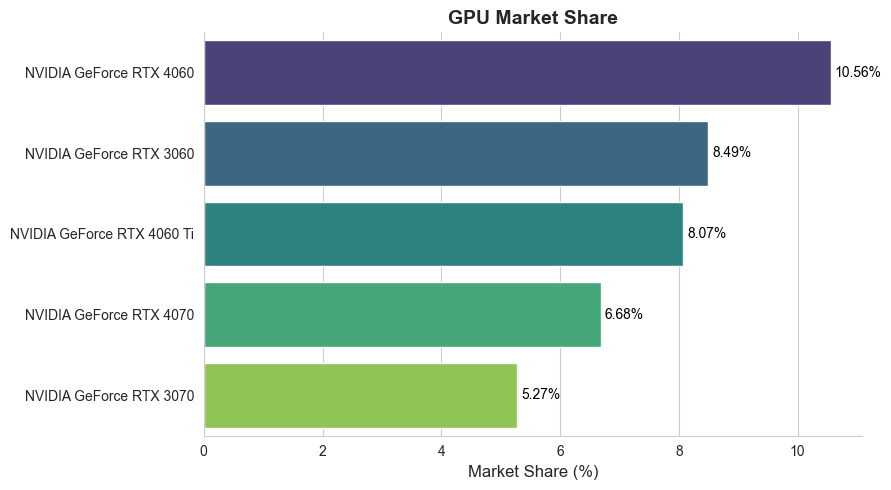

In [11]:
# Configurar o estilo do Seaborn
sns.set_style("whitegrid")

# Criar o gráfico de barras horizontais
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y=most_dominant['gpu_name'], 
    x=most_dominant['market_share'], 
    palette="viridis"
)

# Adicionar os valores dentro das barras (formatados como porcentagem)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10, color='black')

# Personalizar os rótulos e título
plt.xlabel('Market Share (%)', fontsize=12)
plt.ylabel('')
plt.title('GPU Market Share', fontsize=14, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

## How many games each GPU can run on Minimum and Recommended settings

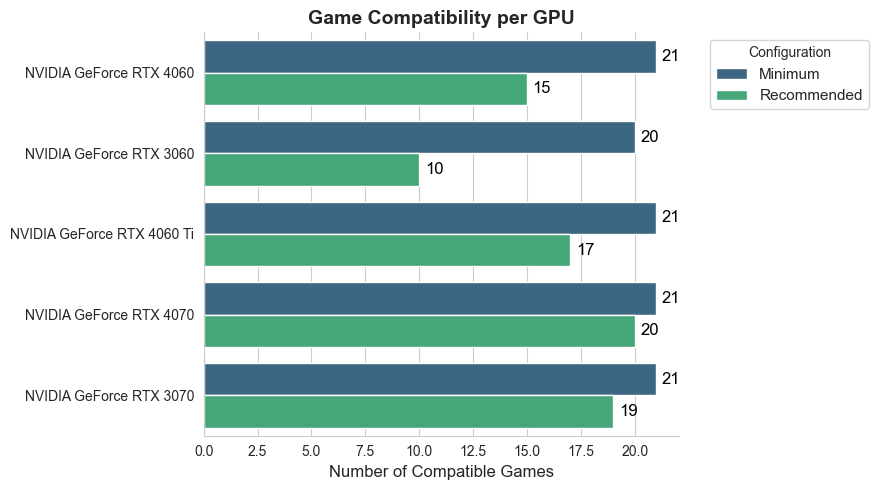

In [12]:
# Function to calculate compatible games
def get_compatible_games(benchmark_score):
    compatible_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    compatible_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    return len(compatible_minimum), len(compatible_recommended)

# Collecting data for the chart
data = []

for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    min_count, rec_count = get_compatible_games(score)
    
    data.append({'GPU': gpu_name, 'Configuration': 'Minimum', 'Compatible Games': min_count})
    data.append({'GPU': gpu_name, 'Configuration': 'Recommended', 'Compatible Games': rec_count})

# Creating a DataFrame for Seaborn
df_plot = pd.DataFrame(data)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the horizontal bar plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y='GPU', x='Compatible Games', hue='Configuration', 
    data=df_plot, palette="viridis", dodge=True
)

# Add values on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=4, fontsize=12, color='black')

# Customize labels
plt.ylabel('')
plt.xlabel('Number of Compatible Games', fontsize=12)
plt.title('Game Compatibility per GPU', fontsize=14, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move the legend outside the chart
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)

# Improve layout to avoid cutting off elements
plt.tight_layout()

# Display the chart
plt.show()

## How many games each GPU can't run on Recommended settings

C:\Users\pedro\AppData\Local\Temp\ipykernel_19980\1402785892.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


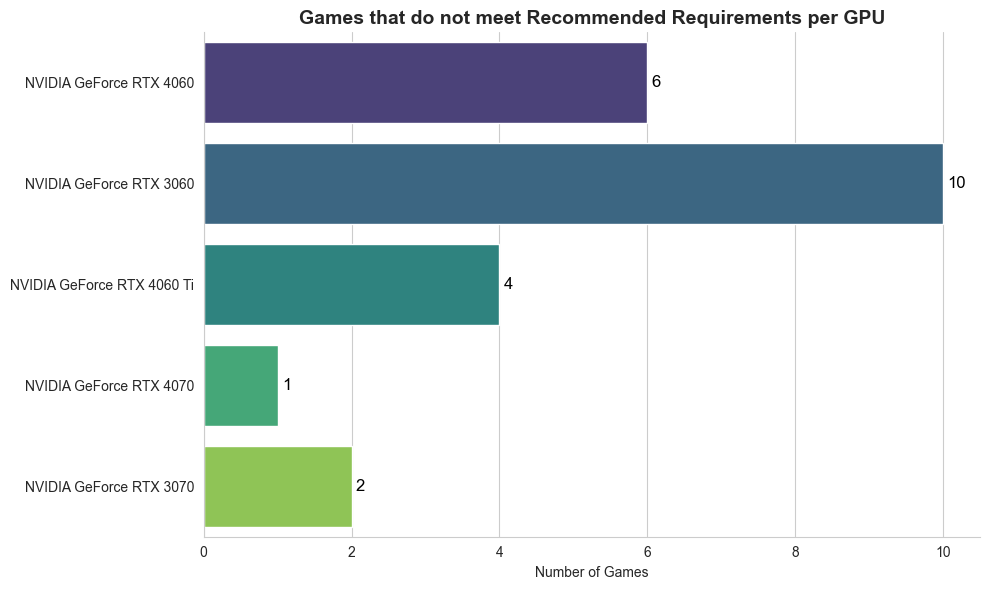

In [13]:
# Função para calcular os jogos que rodam no mínimo, mas não no recomendado
def get_minimum_but_not_recommended(benchmark_score):
    # Jogos que rodam no mínimo
    games_able_to_run_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    
    # Jogos que rodam no recomendado
    games_able_to_run_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    
    # Filtrar jogos que rodam no mínimo, mas não no recomendado
    games_minimum_not_recommended = games_able_to_run_minimum[~games_able_to_run_minimum['game_name'].isin(games_able_to_run_recommended['game_name'])]
    
    return len(games_minimum_not_recommended)

# Coletando os dados para o gráfico
data = []

for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    count_not_recommended = get_minimum_but_not_recommended(score)
    data.append({'GPU': gpu_name, 'Games Not Recommended': count_not_recommended})

# Criando um DataFrame para o Seaborn
df_plot = pd.DataFrame(data)

# Configurando o estilo do Seaborn
sns.set_style("whitegrid")

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Games Not Recommended', y='GPU', data=df_plot, palette="viridis"
)

# Adicionar valores nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=12, color='black')

# Personalizando os rótulos
plt.xlabel('Number of Games')
plt.ylabel('', fontsize=12)
plt.title('Games that do not meet Recommended Requirements per GPU', fontsize=14, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Ajustando layout para não cortar a legenda
plt.tight_layout()

# Exibir o gráfico
plt.show()

## Wich game each GPU can't run on Recommended settings

In [14]:
# Função para calcular os jogos que rodam no mínimo, mas não no recomendado
def get_minimum_but_not_recommended(benchmark_score):
    # Jogos que rodam no mínimo
    games_able_to_run_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    
    # Jogos que rodam no recomendado
    games_able_to_run_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    
    # Filtrar jogos que rodam no mínimo, mas não no recomendado
    games_minimum_not_recommended = games_able_to_run_minimum[~games_able_to_run_minimum['game_name'].isin(games_able_to_run_recommended['game_name'])]
    
    return games_minimum_not_recommended['game_name'].to_list(), games_minimum_not_recommended

# Lista para armazenar os jogos que não rodam no recomendado para cada GPU
all_games_not_recommended = []

# Iterar sobre cada GPU e calcular os jogos que rodam no mínimo, mas não no recomendado
for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    games_list, games_not_recommended_df = get_minimum_but_not_recommended(score)
    
    # Imprimir os resultados
    print(f"GPU: {gpu_name}")
    print(f"Games that run on Minimum but not Recommended: {games_list}\n")
    
    # Armazenar o DataFrame para futuras análises
    all_games_not_recommended.append(games_not_recommended_df)

# Concatenar os DataFrames de todos os jogos que não rodam no recomendado
all_games_not_recommended_data = pd.concat(all_games_not_recommended, ignore_index=True)

GPU: NVIDIA GeForce RTX 4060
Games that run on Minimum but not Recommended: ["Assassin's Creed Shadows", 'inZOI', 'Split Fiction', 'The Last of Us Part I', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 3060
Games that run on Minimum but not Recommended: ["Assassin's Creed Shadows", 'inZOI', 'Split Fiction', 'Monster Hunter Wilds', 'The Last of Us Part I', 'Farming Simulator 25', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'F1 24', 'God of War Ragnarök', 'Call of Duty: Black Ops 6']

GPU: NVIDIA GeForce RTX 4060 Ti
Games that run on Minimum but not Recommended: ['inZOI', 'Split Fiction', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 4070
Games that run on Minimum but not Recommended: ['Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 3070
Games that run on Minimum but not Recommended: ['S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']



---

# Create GPU Count DataFrame

In [15]:
# Create a empty DataFrame
gpu_count = pd.DataFrame()

In [16]:
# Concat Minimun and Recommended GPU
gpu_count['gpu'] = pd.concat([games_requirement_data['gpu_minimum'], games_requirement_data['gpu_recommended']], ignore_index=True)
gpu_count.drop_duplicates(inplace=True)

KeyError: 'gpu_minimum'

In [ ]:
# Minimum GPU count
gpu_minimum_count = games_requirement_data['gpu_minimum'].value_counts().reset_index()

# Recommended GPU count
gpu_recommended_count = games_requirement_data['gpu_recommended'].value_counts().reset_index()

In [ ]:
# Join Minimum GPU count
gpu_count = pd.merge(gpu_count, gpu_minimum_count, how='outer', left_on='gpu', right_on='gpu_minimum')

# Drop column
gpu_count.drop('gpu_minimum', axis=1, inplace=True)

# Join Recommended GPU count
gpu_count = pd.merge(gpu_count, gpu_recommended_count, how='outer', left_on='gpu', right_on='gpu_recommended')

# Drop column
gpu_count.drop('gpu_recommended', axis=1, inplace=True)

In [ ]:
# Fill null values
gpu_count.fillna(0, inplace=True)

# Create a All GPU count column
gpu_count['gpu_total_count'] = gpu_count['count_x'] + gpu_count['count_y']
gpu_count.rename(columns={'count_x':'gpu_minimum_count', 'count_y':'gpu_recommended_count'}, inplace=True)
gpu_count.sort_values(by='gpu_total_count', inplace=True, ascending=False)

# Bar Plot

In [ ]:
gpu_requirements_count = gpu_count.drop('gpu_total_count', axis=1)

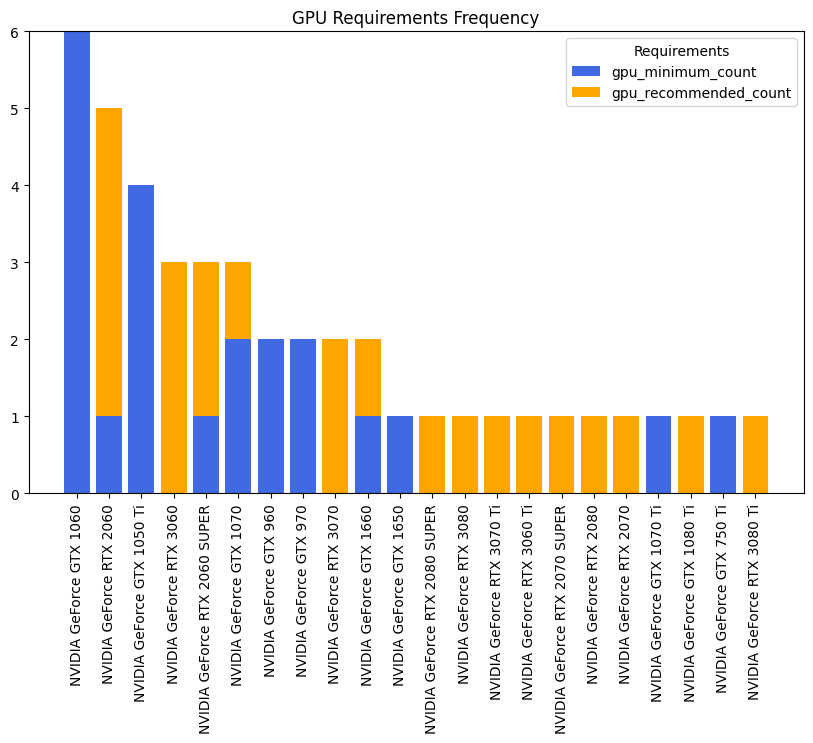

In [ ]:
# Transformando o DataFrame para formato longo
gpu_count_melted = gpu_requirements_count.melt(id_vars="gpu", var_name="requirements", value_name="qtd")

# Criando um pivot mantendo a ordem original
gpu_pivot = gpu_count_melted.pivot(index="gpu", columns="requirements", values="qtd").fillna(0)

# Garantindo a ordem correta das GPUs
gpu_pivot = gpu_pivot.reindex(gpu_requirements_count["gpu"])  

# Configuração do gráfico
plt.figure(figsize=(10, 6))

# Criando barras empilhadas
bottom_values = [0] * len(gpu_pivot)

colors = ["royalblue", "orange"]  # Ajuste conforme a quantidade de categorias
for i, requirement in enumerate(gpu_pivot.columns):
    plt.bar(gpu_pivot.index, gpu_pivot[requirement], bottom=bottom_values, label=requirement, color=colors[i])
    bottom_values += gpu_pivot[requirement]

# Personalização do gráfico
plt.xlabel("")
plt.ylabel("")
plt.title("GPU Requirements Frequency")
plt.xticks(rotation=90)
plt.legend(title="Requirements")
plt.show()